## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import numpy as np
import matplotlib.pyplot as plt

## Loading the dataset

In [ ]:
(training_genoms, training_labels), (test_genoms, test_labels) = tfds.load(
    "genomics_ood", # name of the dataset
    as_supervised=True, # as supervised because we want the labels for each genom as well.
    split=["train[0:100000]", "test[0:1000]"], # we only take the elements 0-100.000 from the train set and 0-1000 from the test set.
    batch_size=(-1) # -1 to get the full dataset as a tf.Tensor
    )

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


## Helper Methods for processing the data

In [ ]:
def onehotify(tensor):
    """onehotify takes in a tensor of a single genom sequence and converts it to a Tensor with only zeros and ones."""
    vocab = {"A":"1", "C":"2", "G":"3", "T":"0"}
    for key in vocab.keys():
      tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot


In [ ]:
def build_pipeline(genoms, labels, batch_size, prefetch_size):
    """takes in respective input genoms and labels and builds a single data pipeline out of it"""
    # Transform input to datasets
    genoms_ds = tf.data.Dataset.from_tensor_slices(genoms)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    # preprocess the data
    genoms_ds = genoms_ds.map(onehotify)
    labels_ds = labels_ds.map(lambda x: tf.reshape(tf.one_hot(x, 10), (-1,)))

    # combine the datasets
    ds = tf.data.Dataset.zip((genoms_ds, labels_ds))

    # make batches and shuffle those
    ds = ds.batch(batch_size)
    ds = ds.shuffle(buffer_size=batch_size)
    ds = ds.prefetch(prefetch_size)

    return ds

## Creating a Model class for our Neuronal Network
The Netowrk will have two fully connected hidden layers with each 256 units and the sigmoid function as their activation function.
The output layer will only have 10 units, one for each of the ten bacteria classes. The activation function in the output layer is the softmax funcion which normalises the output over all the output units.

In [ ]:
# mostly taken from Tensorflow_Intro.ipynb
class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    @tf.function
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

## Defining the training step and test function for measuring the loss and accuracy of the Model

In [ ]:
# taken from Tensorflow_Intro.ipynb
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
      prediction = model(input)
      loss = loss_function(target, prediction)
      gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
      prediction = model(input)
      sample_test_loss = loss_function(target, prediction)
      sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
      sample_test_accuracy = np.mean(sample_test_accuracy)
      test_loss_aggregator.append(sample_test_loss.numpy())
      test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## Start learning
First we get our test and training data pipeline and afterwards we will start the training.

In [ ]:
# Process training and test data
training_ds = build_pipeline(training_genoms, training_labels, batch_size=100, prefetch_size=60)
test_ds = build_pipeline(test_genoms, test_labels, batch_size=100, prefetch_size=60)

In [ ]:
# most things from Tensorflow_Intro.ipynb
tf.keras.backend.clear_session()


## HYPER PARAMETERS
epochs = 10
learning_rate = 0.1


# Initialize NN
model = Model()
# loss
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# optimizer
gradientDescent = tf.keras.optimizers.SGD(learning_rate)

# lists for vizualisation
training_losses = []

test_losses = []
test_accuracies = []

# let's test our Model how it performes on the test dataset before learning
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how our Model performs on training dataset before learning
train_loss, _ = test(model, training_ds, cross_entropy_loss)
training_losses.append(train_loss)

# We train for before specified epochs.
for epoch in range(epochs):
    print('Epoch: __ ' + str(epoch))

    # shuffle the datasets for each epoch
    training_ds = training_ds.shuffle(buffer_size=100)
    test_ds = test_ds.shuffle(buffer_size=100)

    # perform a training step with each entry of our data pipeline and record the loss
    for (genom, label) in training_ds:
        train_loss = train_step(model, genom, label, cross_entropy_loss, gradientDescent)
    training_losses.append(train_loss)

    # check how our Model performs after one learning epoch on our test dataset and record it as well
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


## Visualize our recorded loss and accuracy from the training

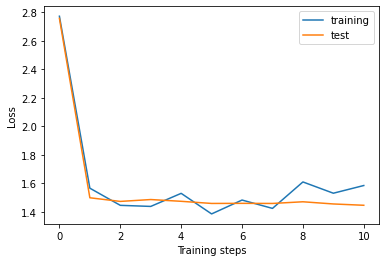

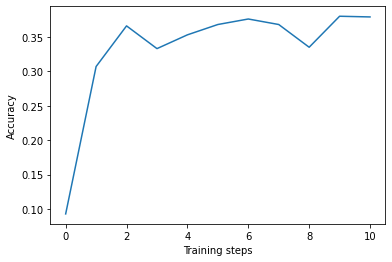

In [ ]:
# taken from Tensorflow_Intro.ipynb

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
